In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.quantum_info import Operator

from penalty import *
from topology import *

key = random.PRNGKey(0)
from jax import custom_jvp, jvp, grad

# Helper functions

In [2]:
@jit
def box_angles(a):
    """Bring angles within range (-pi, pi)"""
    aright = a + jnp.pi
    aright = aright % (2*jnp.pi)
    a_center = aright - jnp.pi
    return a_center

def cz_count(angles, epsilon=1e-2):
    """Count how many angles in cp gates a close to identity, CNOT and generic."""
    count = 0
    for a in angles:
        if jnp.abs(a)<epsilon:
            count += 0
        elif jnp.abs(a-jnp.pi)<epsilon or jnp.abs(a+jnp.pi)<epsilon:
            count += 1
        else:
            count +=2
            
    return count

def TLB(n):
    return int((4**n-3*n-1)/4 + 1)


def random_pair(key, num_qubits):
    key, subkey = random.split(key)
    i, j = random.randint(key, shape=(2,), minval=0, maxval=num_qubits)
    if i==j:
        return random_pair(key, num_qubits)
    else:
        return int(i), int(j)

def random_placements(key, num_qubits, num_cz):
    *keys, _ = random.split(key, num=num_cz+1)
    return [random_pair(key, num_qubits) for key in keys]        

def random_special_unitary(key, num_qubits, num_cz):
    placements = {'free': random_placements(key, num_qubits, num_cz)}
    a = Ansatz(num_qubits, 'cz', placements)
    angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
    return a.unitary(angles), placements



# Max test

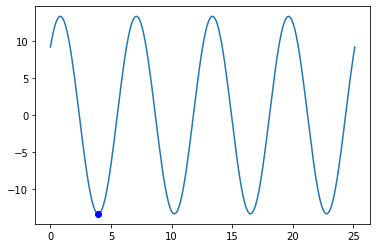

In [3]:
a, b = random.uniform(random.PRNGKey(8), shape=(2,), minval=0, maxval=10)
# a, b = 1, 0
def f(x):
    return a*jnp.cos(x)+b*jnp.sin(x)

x_sweep = jnp.linspace(0, 8*jnp.pi, 200)
plt.plot(x_sweep, vmap(f)(x_sweep))
plt.plot(min_angle(f), f(min_angle(f)), 'bo')


# Test

In [4]:
a = Ansatz(2, 'cz', fill_layers(sequ_layer(2), 3))
u = a.unitary
a.circuit().draw()

┌────────┐┌────────┐┌────────┐   ┌────────┐┌────────┐   ┌─────────┐»
q_0: ┤ RZ(a0) ├┤ RX(a1) ├┤ RZ(a2) ├─■─┤ RY(a6) ├┤ RX(a7) ├─■─┤ RY(a10) ├»
     ├────────┤├────────┤├────────┤ │ ├────────┤├────────┤ │ ├─────────┤»
q_1: ┤ RZ(a3) ├┤ RX(a4) ├┤ RZ(a5) ├─■─┤ RY(a8) ├┤ RX(a9) ├─■─┤ RY(a12) ├»
     └────────┘└────────┘└────────┘   └────────┘└────────┘   └─────────┘»
«     ┌─────────┐   ┌─────────┐┌─────────┐
«q_0: ┤ RX(a11) ├─■─┤ RY(a14) ├┤ RX(a15) ├
«     ├─────────┤ │ ├─────────┤├─────────┤
«q_1: ┤ RX(a13) ├─■─┤ RY(a16) ├┤ RX(a17) ├
«     └─────────┘   └─────────┘└─────────┘

In [5]:
v = unitary_group.rvs(4, random_state=0)
def d2(angles):
    return disc2(u(angles), v)

In [6]:
%%time
angles_history = staircase_min(d2, a.num_angles, n_iterations=1000)

CPU times: user 2.08 s, sys: 7.24 ms, total: 2.09 s
Wall time: 2.08 s


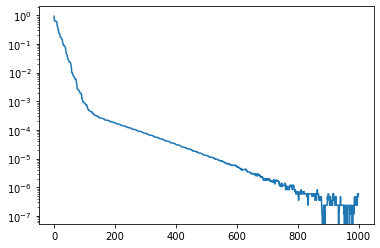

In [7]:
plt.plot(vmap(d2)(angles_history))
plt.yscale('log')

# Benchamrks

In [18]:
# placements = random_placements(random.PRNGKey(0), 3, 14)
a = Ansatz(4, 'cz', fill_layers(sequ_layer(3), 61))
u_target  = unitary_group.rvs(2**4, random_state=41)

In [21]:
%%time
angles_history, loss_history = a.learn(u_target, num_iterations=25000)

CPU times: user 29.6 s, sys: 730 ms, total: 30.3 s
Wall time: 19.9 s


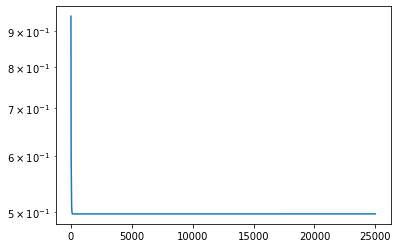

In [22]:
plt.plot(loss_history)
plt.yscale('log')

In [23]:
def ffff(angles):
    return disc2(a.unitary(angles), u_target)

In [27]:
%%time
for _ in range(3):
    ah = staircase_min(ffff, a.num_angles, n_iterations=100000)

CPU times: user 1min 4s, sys: 243 ms, total: 1min 4s
Wall time: 52 s


In [ ]:
plt.plot(jit(vmap(ffff))(ah))
plt.yscale('log')

# Real test

In [10]:
a = Ansatz(5, 'cz', fill_layers(sequ_layer(5), 50))
u = a.unitary
v = unitary_group.rvs(2**5, random_state=14)
# a.circuit().draw()

In [11]:
angles = random.uniform(key, minval=0, maxval=2*jnp.pi, shape=(a.num_angles, ))

@jit
def plain_grad(angles):
    return grad(lambda a: trace2(u, v, a))(angles)

@jit
def shift_grad(angles):
    return grad(lambda a: shift_trace2(u, v, a))(angles)

In [12]:
%%time
pg = plain_grad(angles)

CPU times: user 23.5 s, sys: 26 ms, total: 23.6 s
Wall time: 23.6 s


In [13]:
%%time
sg = shift_grad(angles)

CPU times: user 6.54 s, sys: 7.71 ms, total: 6.55 s
Wall time: 6.55 s


In [14]:
jnp.allclose(pg, sg, rtol=1e-5, atol=1e-6)

DeviceArray(True, dtype=bool)

In [15]:
%timeit plain_grad(angles)

859 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit shift_grad(angles)

59.1 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
